In [ ]:
# prompt: mount drive to colab

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/drive/MyDrive/rsc_joined.csv')

In [ ]:
df.head()

,image_id,upper_left_lat_dec,upper_left_lon_dec,lower_right_lat_dec,lower_right_lon_dec,distance,image_name,description
0,N-34-140-A-d-3-4_0_0.tif,52.188207,21.656291,52.187015,21.658094,9.58,N-34-140-A-d-3-4_0_0.tif,some buildings and many green trees are locate...
1,N-34-140-A-d-3-4_0_512.tif,52.187058,21.656223,52.185866,21.658025,56.32,N-34-140-A-d-3-4_0_512.tif,some buildings and many green trees are in an ...
2,N-34-140-A-d-3-4_0_1024.tif,52.185908,21.656154,52.184716,21.657956,47.51,N-34-140-A-d-3-4_0_1024.tif,some buildings and many green trees are locate...
3,N-34-140-A-d-3-4_0_1536.tif,52.184758,21.656086,52.183566,21.657888,41.42,N-34-140-A-d-3-4_0_1536.tif,many green trees are in a square area.
4,N-34-140-A-d-3-4_0_2048.tif,52.183608,21.656017,52.182416,21.657819,77.40,N-34-140-A-d-3-4_0_2048.tif,a road is near a piece of green meadow.


In [ ]:
df = df.sort_values('distance', ascending=True)
df.head()

,image_id,upper_left_lat_dec,upper_left_lon_dec,lower_right_lat_dec,lower_right_lon_dec,distance,image_name,description
966,M-34-51-C-d-4-1_7168_8192.tif,50.356588,19.212626,50.355434,19.214421,0.59,M-34-51-C-d-4-1_7168_8192.tif,some green trees are near a river with two cars.
83,N-34-140-A-d-3-4_2048_3584.tif,52.179989,21.663294,52.178797,21.665095,0.60,N-34-140-A-d-3-4_2048_3584.tif,many green trees and some buildings are locate...
6985,M-34-65-D-d-4-1_7680_1536.tif,50.038269,20.464219,50.037095,20.465971,0.74,M-34-65-D-d-4-1_7680_1536.tif,two parallel roads are between two pieces of f...
4631,M-34-77-B-c-2-3_2048_0.tif,49.896113,20.319636,49.894941,20.321387,1.30,M-34-77-B-c-2-3_2048_0.tif,some buildings and many green trees are locate...
3672,M-34-65-D-c-4-2_3584_5120.tif,50.030376,20.355946,50.029204,20.357701,1.43,M-34-65-D-c-4-2_3584_5120.tif,many green trees are in a piece of forest.


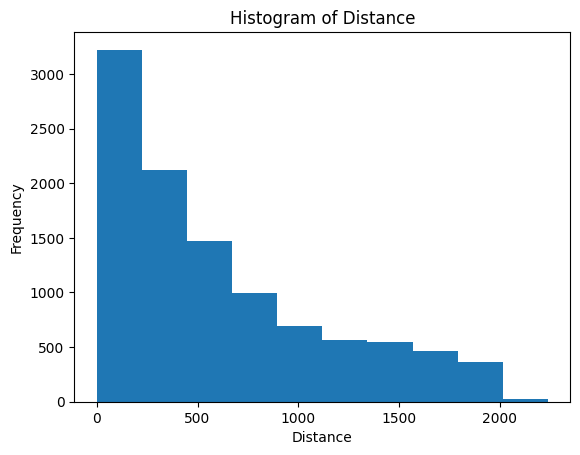

In [ ]:
# prompt: display a histogram of the distance column

import matplotlib.pyplot as plt

plt.hist(df['distance'])
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Distance')
plt.show()


In [ ]:
# prompt: how many samples in df have distance < 500, and < 1000

print(f"Number of samples with distance < 500: {(df['distance'] < 300).sum()}")
print(f"Number of samples with distance < 1000: {(df['distance'] < 400).sum()}")

Number of samples with distance < 500: 4018
Number of samples with distance < 1000: 4929


In [ ]:
filtered_df = df[df['distance'] <= 500]

filtered_df.shape

(5718, 8)

connect s3 bucket

In [ ]:
!pip install -q torch Pillow tqdm transformers

In [ ]:
!pip install -q boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 3.9 MB/s eta 0:00:00


In [ ]:
!pip install -q --upgrade awscli

In [ ]:
!aws configure

In [ ]:
import os

os.environ["OPENAI_API_KEY"] = "_"

In [ ]:
!pip -q install openai

In [ ]:
import openai
import base64
from io import BytesIO

def augment_text(image, distance, description):
    """
    Augments text using the given image (Pillow Image object), distance, and description.
    Encodes the image and sends the combined input to the OpenAI GPT-4 API.

    Args:
        image (PIL.Image.Image): The input image as a Pillow Image object.
        distance (float): Distance value for contextual use.
        description (str): Textual description to augment.

    Returns:
        str: The generated augmented text.
    """
    try:
        # Step 1: Encode the image in Base64
        buffer = BytesIO()
        image.save(buffer, format="PNG")  # Save the image to a buffer in PNG format
        img_base64 = base64.b64encode(buffer.getvalue()).decode("utf-8")  # Encode the buffer content

        # Step 2: Construct the prompt using the inputs
        prompt = f"""
        You are an expert in enhancing geospatial data captions.

        Context:
        - A remote sensing image has been analyzed.
        - A street view image taken {distance} meters away from the remote sensing image location is provided.
        - The following caption describes the scene in the remote sensing image: "{description}"

        Task:
        - Augment the provided caption by incorporating relevant contextual details observed in the provided street view image if possible
        - Focus on objective features that enhance the spatial understanding of the scene (e.g., building types, road structures, vegetation presence, or land use).
        - Avoid mentioning type of imagery (e.g., street view, remote sensing),
        - Avoid mentioning details about weather, vehicles, or background
        - Avoid using subjective language such as "lush" or "beautiful"

        Example:
        Input: "Some buildings and a field."
        Output: "Multiple homes next to a paved road and a small agricultural field."

        Limit output to 20 words. Use very basic language.
        """

        # Step 3: Call the OpenAI GPT-4 API
        response = openai.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt},
                {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/png;base64,{img_base64}",
                },
                },
            ],
            }
        ],
        max_tokens=30,
        temperature=0)
        content = response.choices[0].message.content
        return content

        # Step 4: Extract and return the generated text
        content = response.choices[0].message.content
        return content
    except Exception as e:
        print(f"Error in augment_text: {e}")
        return None


In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import boto3
from botocore.exceptions import ClientError
from PIL import Image
from tqdm import tqdm

def process_images_parallel(bucket_name, subfolder, input_df, output_csv, max_workers=4):
    """
    Processes images from an S3 bucket, matches them with input CSV rows, augments text,
    and writes the output to a CSV file using parallel processing.

    Args:
        bucket_name (str): The name of the S3 bucket.
        subfolder (str): The subfolder within the S3 bucket.
        input_df (pd.DataFrame): Input dataframe containing `image_id`, `distance`, and `description`.
        output_csv (str): Path to save the output CSV with `image_id` and augmented `description`.
        max_workers (int): Number of parallel threads to use.
    """
    # Initialize the S3 client
    s3_client = boto3.client('s3')

    # Fetch the list of image keys in the subfolder
    print(f"Fetching list of images from '{bucket_name}/{subfolder}'...")
    image_keys = []
    try:
        continuation_token = None
        while True:
            if continuation_token:
                response = s3_client.list_objects_v2(
                    Bucket=bucket_name,
                    Prefix=subfolder,
                    ContinuationToken=continuation_token
                )
            else:
                response = s3_client.list_objects_v2(
                    Bucket=bucket_name,
                    Prefix=subfolder
                )

            if 'Contents' not in response:
                print("No images found in the specified subfolder.")
                break

            image_keys.extend(
                [content['Key'] for content in response['Contents'] if content['Key'].endswith('.jpg')]
            )

            if response.get('IsTruncated'):
                continuation_token = response['NextContinuationToken']
            else:
                break
    except ClientError as e:
        print(f"Error accessing bucket: {e}")
        return

    print(f"Total images found: {len(image_keys)}")

    # Define a function to process a single row
    def process_row(row):
        image_id = row['image_id']
        distance = row['distance']
        description = row['description']

        matching_image_key = next(
            (key for key in image_keys if image_id in key), None)

        if not matching_image_key:
            print(f"No matching image found for image_id: {image_id}")
            return {'image_id': image_id, 'description': "No matching image"}

        try:
            img_response = s3_client.get_object(Bucket=bucket_name, Key=matching_image_key)
            image_data = img_response['Body'].read()
            with Image.open(BytesIO(image_data)) as image:
                image = image.convert("RGB")
                augmented_text = augment_text(image, distance, description)
                return {'image_id': image_id, 'description': augmented_text.strip('"')}
        except Exception as e:
            print(f"Error processing {matching_image_key}: {e}")
            return {'image_id': image_id, 'description': f"Error: {e}"}

    # Use ThreadPoolExecutor to process rows in parallel
    results = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_row = {executor.submit(process_row, row): row for _, row in input_df.iterrows()}
        for future in tqdm(as_completed(future_to_row), total=len(future_to_row), desc="Processing rows"):
            results.append(future.result())

    # Write the results to the output CSV
    output_df = pd.DataFrame(results)
    output_df.to_csv(output_csv, index=False)
    print(f"Output saved to {output_csv}")

process_images_parallel(
    bucket_name='_',
    subfolder='_',
    input_df=filtered_df,
    output_csv='/content/drive/MyDrive/augmented_descriptions.csv')

Fetching list of images from 'ibm-rsc/street_images'...
Total images found: 10473


Processing rows:   3%|▎         | 148/5718 [01:55<52:08,  1.78it/s]  

Error in augment_text: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-A36sbKSNXbdhdr0n6YtGJTtV on tokens per min (TPM): Limit 200000, Used 199447, Requested 1080. Please try again in 158ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}
Error processing street_images/M-33-20-D-d-3-3_7680_8704.tif.jpg: 'NoneType' object has no attribute 'strip'


Processing rows:   3%|▎         | 172/5718 [02:09<35:33,  2.60it/s]

Error in augment_text: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-A36sbKSNXbdhdr0n6YtGJTtV on tokens per min (TPM): Limit 200000, Used 199301, Requested 1089. Please try again in 117ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}
Error processing street_images/N-33-130-A-d-4-4_7168_2560.tif.jpg: 'NoneType' object has no attribute 'strip'


Processing rows:   4%|▎         | 209/5718 [02:32<55:16,  1.66it/s]